# SIR

Any disease model will share some things in common. It will need to represent the population of people being modelled, some (or all) of whom will get the disease in the course of the outbreak. It will need to represent the progress of the disease, as people are infected, become infectious, recover, and so forth. It will need some notion of how the disease spreads between people. And it will need to represent the disease dynamics, how long the various stages of the disease take, how virulently it spreads in the population, and so on.

There are lots different ways to represent these phenomena, and each choice gives rise toi a different modelling approach. There are a lot of trade-offs to be made, with more detail allowing more subtle issues to be captured and explored at the cost of making the model more complicated to understand and compute.  

Let's start with what is perhaps the simplest model of an epidemic, the *SIR model*.

## SIR: A compartmented model of disease

SIR is referred to as a *compartmented model* of disease. It represents the progress of the disease by specifying a umber of states or *compartments*, with everyone in the population being assigned to exactly one compartment at anytime. The disease progresses by having people move between compartments according to some process.

SIR, as its name suggests, uses three compartments:

- *Susceptible (S)*, representing those people who can catch the disease;
- *Infected (I)*, representing those people who have cauight the disease and can pass it on; and
- *Removed (R)*, representing those people whose infection has resolved itself and have been "removed" from progressing the disease any further.

Notice how simple this is. A person is either infected, or they're not. If they *are* infected, they are infectious: there's no latency. And they're "removed" when their infection resolves, without us noting whether they recovered or died.

You might ask whether something this simple can tell us anything: does any real disease work like this? But the simplicity of the model amkes it tractable and easy to study, and once we've got a feel for how these things work we can if desired move onto more detailed models. SIR is just one of the possible compartmented models: the others include SIS (for diseases where you can be re-infected once recovered), SEIR (for diseases with an infectious period when someone has been "exposed"), MSEIR (for diseases with maternally-conferred temporary immunity), so so on in dizzying array (see Hethcote{cite}`Heth00` for a more detailed discussion). 

## The mathematical model

We now need to describe how individuals move between compartments.  Actually we'll simply talk about the *numbers* of people in each compartment at each time, and how those numbers change: we won't track the disease's progress in a specific individual (there's a whole class of *agent-based* models that do do this).

Suppose we have a population of size $N$. Let's represent the number of pewople in each compartment by $S$, $I$, and $R$ respectively. Everyone in the population is assigned to exactly one compartment at any time, so always $S + I + R = N$ as the sub-populations $S$, $I$, and $R$ change.

How does someone become infected? &ndash; that is to say, how does someone move between compartment $S$ and compartment $I$? In SIR we assume that the infection passes through contact between a susceptible individual and an infected one. If we further assume that everyone in the population meets everyone else equally often, then there will be $S \times I = SI$ encounters between susceptible and infected individuals in each time period. Think of the population as crowd milling around, some of whom are infected. 

Clearly not all of these interactions will result in an infection, but some fraction will, and the result will be that and an individual moves from $S$ to $I$: remember that in SIR we assume that the disease passes on instantly. Let's refer to this as $p_{infect}$, the probability that an $I$ will infect an $S$ in a single contact. There are $SI$ contacts in each timestep, of which a fraction $p_{\mathit{infect}}$ will result in an infection. Putting this all together, the size of $S$ will *reduce* by $p_{\mathit{infect}} \, SI$ (because the disease causes people to leave $S$ by becoming infected).

If $S$ is the number of susceptible people, we can denote the *change* in $S$ by $\Delta S$, the difference in $S$ at each timestep. As the disease progresses we expect $S$ to decrease: unless people enter the population from outside, the number of susceptible people only goes down since once someone has been infected they don't return to being susceptible again (having the disease makes you immune). Mathematically we can say that

$$
    \Delta S = -p_{\mathit{infect}} \, SI
$$

with the minus sign indicating that $S$ is getting smaller.

What about $I$? Every person who leaves $S$ (and so ceases to be susceptible) becomes infected and so enters $I$. So we'd expect that the corresponding change in $I$, $\Delta I$, would *increase* the the same amount as $\Delta S$ *decreased*, so as not to lose anyone from the population. But as well as contracting the disease, people also recover from it (or die): either way are "removed" from the population affected by the disease.

(Whether you recover or die is obviously quite important to you, but in either event you are no longer infected or susceptible and so take no further part in the spread of the infection. Epidemic modelling can seem quite heartless at times.)

```{margin}
In the computational epidemiology and network science literatures the
parameter we've called $p_{\mathit{infect}}$ is usually denoted
$\beta$, while $p_{remove}$ is denoted $\alpha$. It's easier to
understand what's going on if we spell the meaning of the symbols out.
```

How many people are removed? SIR assumes that, just as a fraction $p_{\mathit{infect}}$ of contacts result in infection, a fraction $p_{remove}$ of infected individuals are removed. So the size of $I$ is *increased* by susceptible people becoming infected, and *reduced* by infected people becoming removed. Putting this together we get

$$
    \Delta I = (p_{\mathit{infect}} \, SI) - (p_{remove} \, I)
$$

The final step in the model is to account for removal, whereby the size of $R$ increases at the same rate as that of $I$ decreases.

$$
    \Delta R = p_{remove} \, I
$$

And that's SIR: three equations that describe how the sizes of the three compartments change, and two parameters that define what fraction of contacts result in infections and what fraction of infections are removed in a given time period.

Looking at the maths immediately tells us some things about how an SIR epidemic will progress. Firstly, as we mentioned, the size of $S$ always decreases, while the size of $R$ clearly always increases: the only place where anything interesting can happen is in the size of $I$, whhich both increases *and* decreases.

Secondly, the rate at which $I$ increases depends on how big $I$ is already: a larger value of $I$ makes for a larger value of $\Delta I$. But it's a bit more complicated than that, since it also depends on the size of $S$, where a smaller value of $S$ means a smaller value of $\Delta I$ &ndash; and we know that $S$ is always getting smaller. So these two terms &ndash; growing through infection and shrinking through removal &ndash; will fight it out as the disease progresses. 

To summarise, we know that the sizes of $S$, $I$, and $R$ will change over time. We know that $S$ will shrink and $R$ will grow, and $I$ will ... well, will do something that depends on the sizes of $S$ and $I$. We also know that $I$ grows at the same rate that $S$ shrinks.

To find out exactly what happens, we need to explore these equations.

## The computational model

To explore SIR, let's turn the mathematical model of three equations into a computational model that "runs the numbers" to show how the epidemic progresses.

In [2]:
import numpy

We can represent each of the three chanmges in population directly as Python functions. Since they share the parameters $p_{\mathit{infect}}$ and $p_{remove}$, we'll define them together using another function to which we pass the parameters and get back the change functions.

In [3]:
def make_sir(pInfect, pRemove):
    # turn the equations into update functions
    def deltaS(S, I, R):
        return -pInfect * S * I
    def deltaI(S, I, R):
        return pInfect * S * I - pRemove * I
    def deltaR(S, I, R):
        return pRemove * I
    
    # return the three functions
    return (deltaS, deltaI, deltaR)

We've used as far as possible the same names in the code as we did in the maths: `pInfect` for $p_{\mathit{infect}}$, `deltaS` for $\Delta S$, and so forth. This will help keep things straight in our minds.

```{margin}
This approach to integration to get a time series, known as the
*direct* or *Euler* method, isn't safe in general, as it risks falling
foul of numerical instability in the equations. There are several more
robust solutions for the more complex cases, notably the Runge-Kutta
methods that are built into Python's `scipy` library.
```

How do we "run" the epidemic? We've defined the ways in which the sizes of the sub-populations change. If we start with some initial sub-populations, we can then compute the change and add it to the previous population to get the population at the next timestep. We can do this repeatedly to trace out the behaviour of the epidemic in time. The result will be a time series for each sub-population tracking its size over time.

What should the initial sizes of the sub-populations be? Since we're interested only in their sizes, we could say that given $N$ individuals a fraction $p_{\mathit{infected}}$ are initially infected, while everyone else is susceptible: no-one starts off removed.

We can code this behaviour up as a single function.

In [4]:
def epidemic_sir(T, N, pInfected, pInfect, pRemove):
    # create the change functions for these parameters
    (deltaS, deltaI, deltaR) = make_sir(pInfect, pRemove)
    
    # initial conditions
    sss = [ N * (1.0 - pInfected) ]   # everyone is initially susceptible...
    iss = [ N * pInfected ]           # ...except for this fraction of people...
    rss = [ 0 ]                       # ...and no-one starts off removed

    # push the initial conditions through the equations
    for t in range(1, T):
        # apply the change functions to the sub-populations of 
        # the previous timestep to compute the changes
        ds = deltaS(sss[-1], iss[-1], rss[-1])
        di = deltaI(sss[-1], iss[-1], rss[-1])
        dr = deltaR(sss[-1], iss[-1], rss[-1])
        
        # the value at the next timestep are those at the previous
        # timestep plus the value of the change in that value
        sss.append(sss[-1] + ds)
        iss.append(iss[-1] + di)
        rss.append(rss[-1] + dr)
        
    # return the time series
    return (list(range(0, T)), sss, iss, rss)

We need the initial conditions for the simulation: the population size (which won;t change), the number of timesteps we want to run the simulation for, and the values of the three parameters `pInfected`, `pInfect`, and `pRemove`. For simplicity let's fix all these apart from `pInfect`. We'll start with $1/100\mathrm{th}$ of the population infected (`pInfected = 0.01`), and $1/1000\mathrm{th}$ of the infected population recovering in each timestep (`pRemove = 0.001`). 

In [5]:
N = 1000
T = 5000
pInfected = 0.01
pRemove = 0.001

We can then choose different values of `pInfect` and see what the simulation shows us about the ways in which the sub-populations evolve. 

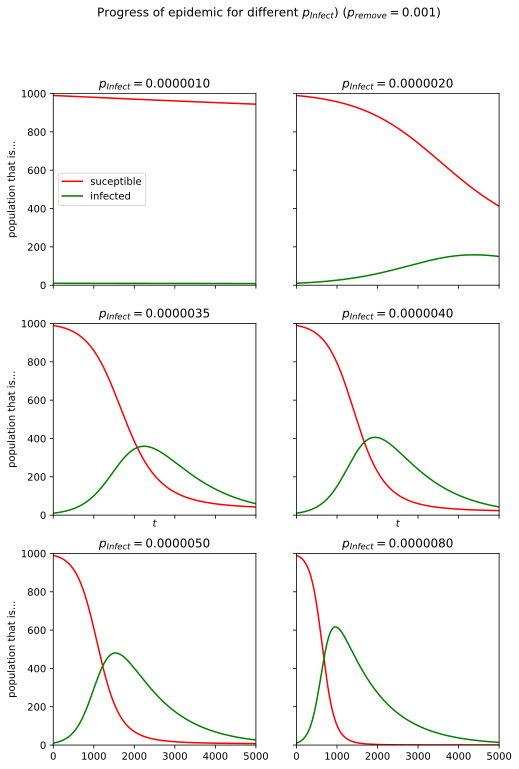

In [8]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import seaborn

(fig, axs) = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(8, 12))

# draw the sub-plots for selected values of pInfect
for (pInfect, ax) in [ (0.0000010, axs[0][0]),
                       (0.0000020, axs[0][1]),
                       (0.0000035, axs[1][0]),
                       (0.0000040, axs[1][1]),
                       (0.0000050, axs[2][0]),
                       (0.0000080, axs[2][1]) ]:
    # run the epidemic equations
    (ts, sss, iss, rss) = epidemic_sir(T, N, pInfected, pInfect, pRemove)
    
    # draw the graph in the sub-plot
    ax.plot(ts, sss, 'r-', label='suceptible')
    ax.plot(ts, iss, 'g-', label='infected')
    #ax.plot(ts, rss, 'k-', label='removed')
    ax.set_title('$p_{\\mathit{Infect}} = ' + '{b:.7f}$'.format(b=pInfect))
    ax.set_xlim([0, T])
    ax.set_ylim([0, N])
    
# fine-tune the figure
plt.suptitle('Progress of epidemic for different $p_{\\mathit{Infect}})$ ($p_{remove} = ' + '{a}$)'.format(a=pRemove))
for i in [0, 1, 2]:
    axs[i][0].set_ylabel('population that is...')
for i in[0, 1]:
    axs[1][i].set_xlabel('$t$')
axs[0][0].legend(loc='center left')
plt.show()

```{margin}
We've engaged in some mathematical sleight-of-hand here, in that what
we've described as a *discrete* model (of people being susceptible,
infected, and so on) has then be treated as a *continuous* model that
represents the sizes of compartments as real numbers. In order to work
in this way the three SIR equations should really be be phrased as
*differential* equations rather than as *difference* equations so that
the passage from discrete to continuous time makes mathematical
sense. The results obtained are the same in both cases, however.
```

What are these graphs telling us? Start in the top left. At the start of the epidemic (when $t = 0$) we have a very small number of infected individuals and a very large number of susceptibles. The number of infecteds grows slowly as the time passes and the graph moves form left to right. But the disease is not very infectious: only 0.000001 of contacts leads to infection, just one in a million. At the start of the epidemic there are 990 susceptible people and 10 infecteds (1% of the total population), which means there can be at most 9900 susceptible-infected contacts. In the first timestep, then, the equations suggest that approximately 0.01 people become infected.

We can't infect two-hundreths of a person, of course: clearly it will take some time for there to be one new person infected. And once infections start people also start to recover, and the epidemic clearly never gets going.

But now look at the next diagrams. Even for very modest values of $p_{\mathit{infect}}$ &ndash; 0.000002 to 0.000008 &ndash; we get considerable epidemics. At the peak of infections around 40&ndash;60% of the population is infected, compared to essentially no-one for the smallest value of $p_{\mathit{infect}}$. And that's with $p_{\mathit{infect}}$ still tiny: eight contacts in every million resulting in an infection.

## Consequences

Let those figures sink in for a moment.

The SIR model is telling us that changing the rate of infection from one in a million to eight in a million is enough to change the total proportion of infected people in a population from about 1% to about 60%! To put it another way, anything that changes the infection rate by even a miniscule amount can have an enormous, outsized, effect on the outbreak.  

We have to be careful what we conclude, though. While we'va got  a "population" and some "contacts", we haven't said anything about the timescale over which we're talking: it's all been abstracted. So the "infection rate" is a somewhat notional concept that doesn't directly relate to *any* particular rate or disease in the real world. It's important to remember this and not draw any unsupported conclusions.

There *are* some conclusions that are supported, though. Firstly, we can see that the epidemic grows exponentially once it gets started. We can also see that it dies away exponentially after its peak. And e know that the population of infected people is a dynamic thing, with people recovering and new people being infected across the outbreak.
